## Krok 1: Instalacja i import bibliotek

Używamy **PyCaret** - to narzędzie, które automatyzuje proces machine learning.
Nie musimy pisać skomplikowanego kodu - PyCaret zrobi to za nas!

In [ ]:
# Instalujemy PyCaret (tylko raz, przy pierwszym uruchomieniu)
# pip install pycaret

In [1]:
# Importujemy potrzebne narzędzia
import pandas as pd  # Do pracy z tabelami danych
import numpy as np  # Do obliczeń matematycznych
import matplotlib.pyplot as plt  # Do tworzenia wykresów
import seaborn as sns  # Do ładniejszych wykresów
from pycaret.clustering import *  # PyCaret do klastrowania

# Ustawienia dla ładniejszych wykresów
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Krok 2: Wczytanie danych

Wczytujemy dane klientów z pliku CSV (jak Excel, ale prostszy).

In [2]:
# Wczytujemy dane z pliku CSV
df = pd.read_csv('data/Mall_Customers.csv')

# Zobaczmy pierwsze 5 wierszy (pierwszych 5 klientów)
print("📊 Pierwsze 5 klientów w naszej bazie:")
print(df.head())

📊 Pierwsze 5 klientów w naszej bazie:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [3]:
# Podstawowe informacje o danych
print("\n📈 Informacje o danych:")
print(f"Liczba klientów: {len(df)}")
print(f"\nKolumny w danych: {list(df.columns)}")
print(f"\nStatystyki opisowe:")
print(df.describe())


📈 Informacje o danych:
Liczba klientów: 200

Kolumny w danych: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Statystyki opisowe:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


## Krok 3: Przygotowanie danych do klastrowania

**Co robimy:**
- Usuwamy kolumny, które nie pomogą w grupowaniu (CustomerID, Gender)
- Zostawiamy tylko liczby: wiek, dochód, punkty wydatków

**Dlaczego?**
Model matematyczny K-Means działa tylko na liczbach i mierzy odległości między klientami.
ID klienta to tylko etykietka, nie pomaga w grupowaniu.

In [4]:
# Tworzymy kopię danych do analizy
# Zostawiamy tylko kolumny numeryczne, które mają sens biznesowy
data_for_clustering = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].copy()

print("✅ Dane przygotowane do klastrowania:")
print(data_for_clustering.head())

✅ Dane przygotowane do klastrowania:
   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40


## Krok 4: Inicjalizacja PyCaret

**Co to robi?**
PyCaret przygotowuje dane automatycznie:
- **Normalizacja** - sprawia, że wszystkie liczby są w podobnej skali (żeby wiek '25' nie był ważniejszy niż dochód '50', bo mają różne jednostki)
- Przygotowuje dane do modelowania

**silent=True** - nie pokazuje wszystkich szczegółów technicznych

In [6]:
# Inicjalizujemy PyCaret dla klastrowania
# normalize=True oznacza, że wszystkie dane będą w tej samej skali
cluster_setup = setup(
    data=data_for_clustering,
    normalize=True,  # Skalujemy dane do tej samej jednostki
    session_id=123  # Dla powtarzalności wyników
)

print("✅ PyCaret skonfigurowany i gotowy do pracy!")

,Description,Value
0,Session id,123
1,Original data shape,"(200, 3)"
2,Transformed data shape,"(200, 3)"
3,Numeric features,3
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


✅ PyCaret skonfigurowany i gotowy do pracy!


## Krok 5: Dobór optymalnej liczby klastrów

**Pytanie:** Ile grup klientów powinniśmy stworzyć? 3? 5? 10?

**Metoda Elbow (Łokcia):**
- Testujemy różne liczby klastrów (od 2 do 10)
- Szukamy "łokcia" na wykresie - punktu, gdzie dodawanie kolejnych grup nie poprawia znacząco podziału
- To jest jak dzielenie uczniów w szkole na grupy - 2 grupy to za mało, 50 to za dużo, szukamy złotego środka

  File "c:\Users\Lukasz\.conda\envs\ml-portfolio-env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Lukasz\.conda\envs\ml-portfolio-env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Lukasz\.conda\envs\ml-portfolio-env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Lukasz\.conda\envs\ml-portfolio-env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


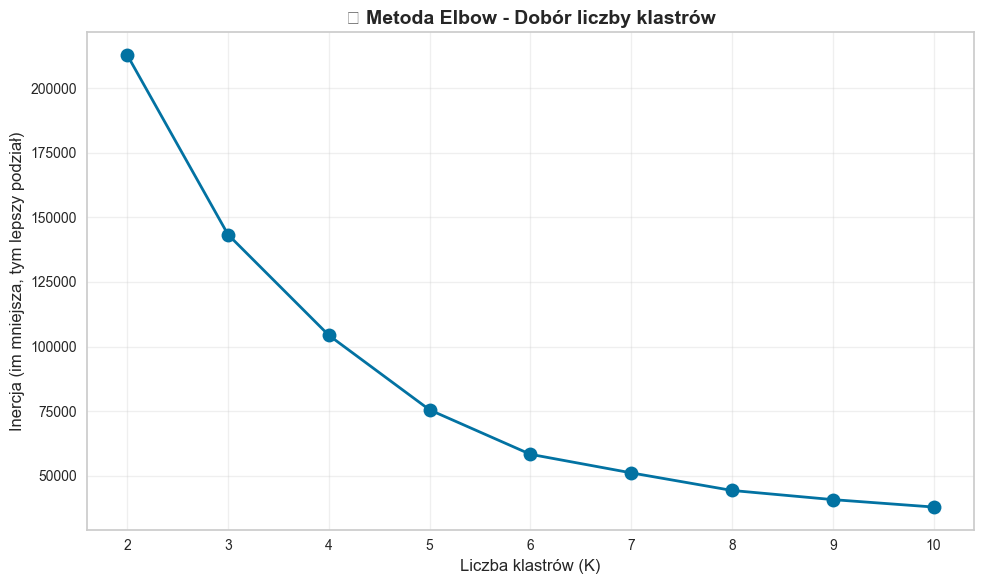


💡 Wskazówka: Szukaj 'łokcia' na wykresie - punktu, gdzie linia zaczyna się łagodzić.
   To będzie optymalna liczba klastrów dla naszych danych!


In [7]:
# Metoda Elbow - pomaga wybrać optymalną liczbę klastrów
from sklearn.cluster import KMeans

# Pobieramy przetworzone dane z PyCaret
X = get_config('X')

# Testujemy różne liczby klastrów od 2 do 10
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Rysujemy wykres Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Liczba klastrów (K)', fontsize=12)
plt.ylabel('Inercja (im mniejsza, tym lepszy podział)', fontsize=12)
plt.title('📊 Metoda Elbow - Dobór liczby klastrów', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

print("\n💡 Wskazówka: Szukaj 'łokcia' na wykresie - punktu, gdzie linia zaczyna się łagodzić.")
print("   To będzie optymalna liczba klastrów dla naszych danych!")

## Krok 6: Tworzenie modelu K-Means

**Na podstawie wykresu Elbow wybieramy liczbę klastrów.**

Dla danych Mall Customers zazwyczaj optymalne są **5 klastrów** (widzimy "łokieć" na wykresie przy k=5).

**K-Means** to algorytm, który:
1. Losuje środki grup
2. Przypisuje każdego klienta do najbliższej grupy
3. Przesuwa środki grup
4. Powtarza kroki 2-3 aż grupy się ustabilizują

In [8]:
# Tworzymy model K-Means z 5 klastrami
# (możesz zmienić num_clusters jeśli wykres Elbow wskazuje inną wartość)
kmeans_model = create_model(
    model='kmeans',  # Używamy algorytmu K-Means
    num_clusters=5   # Liczba grup klientów
)

print("✅ Model K-Means utworzony z 5 klastrami!")

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4166,125.1009,0.8746,0,0,0


✅ Model K-Means utworzony z 5 klastrami!


To są **metryki oceny jakości klastrowania** - pokazują, jak dobrze model podzielił klientów na grupy.
📊 Wyjaśnienie każdej metryki (dla nietechnicznego użytkownika):

🎯 **Silhouette Score: 0.4166**
- **Co mierzy:** Jak blisko są klienci w swojej grupie i jak daleko od innych grup
- **Skala:** -1 do 1 (im wyższy, tym lepiej)
- **Twój wynik:** 0.42 = **przyzwoity podział** (nie idealny, ale całkiem dobry)
- **Interpretacja:** Grupy są widoczne, ale mogą się trochę nachodzić

📏 **Calinski-Harabasz: 125.1**
- **Co mierzy:** Stosunek rozproszenia między grupami do rozproszenia wewnątrz grup
- **Skala:** Im wyższy, tym lepiej (brak górnej granicy)
- **Twój wynik:** 125 = **dobry wynik** (grupy są wyraźnie oddzielone)

⚖️ **Davies-Bouldin: 0.8746**
- **Co mierzy:** Średnie podobieństwo każdej grupy do najbardziej podobnej innej grupy
- **Skala:** 0 do ∞ (im **niższy**, tym lepiej!)
- **Twój wynik:** 0.87 = **bardzo dobry** (grupy są dobrze rozdzielone)

🏷️ **Homogeneity: 0**
- **Co mierzy:** Czy każdy klaster zawiera tylko jedną klasę
- **Dlaczego 0:** Bo w **klastrowaniu nie mamy prawdziwych etykiet!**
- **Ignoruj tę metrykę** - dotyczy tylko sytuacji, gdy znamy prawdziwe grupy

🎲 **Rand Index: 0**
- **Co mierzy:** Zgodność klastrów z prawdziwymi etykietami
- **Dlaczego 0:** Znowu - **nie mamy prawdziwych etykiet**
- **Ignoruj tę metrykę**

✅ **Completeness: 0**
- **Co mierzy:** Czy wszystkie elementy tej samej klasy są w tym samym klastrze
- **Dlaczego 0:** **Brak prawdziwych etykiet**
- **Ignoruj tę metrykę**

---

🎯 **Podsumowanie dla Twojego modelu:**

✅ **Silhouette (0.42)** - Przyzwoite, grupy są widoczne  
✅ **Calinski-Harabasz (125)** - Dobry, grupy wyraźnie oddzielone  
✅ **Davies-Bouldin (0.87)** - Bardzo dobry, niski overlap  

**Wniosek:** Twój model działa dobrze! 5 klastrów to dobry wybór. 👍

Równolegle sprawdzono również model z 4 klastrami i metryki w przypadku 4 klastrów były nieco gorsze, dlatego pozostawiono 5 klastrów jako lepszy wybór.
Metryki dla 4 klastrów wyglądały następująco:
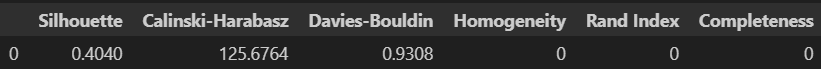

## Krok 7: Przypisanie klientów do klastrów

Teraz każdy klient dostanie numer swojej grupy (0, 1, 2, 3, lub 4).

In [9]:
# Przypisujemy każdego klienta do odpowiedniego klastra
results = assign_model(kmeans_model)

# Dodajemy informację o klastrze do oryginalnych danych
df['Cluster'] = results['Cluster']

print("✅ Klienci przypisani do klastrów!")
print("\n📊 Pierwsze 10 klientów z przypisanymi klastrami:")
print(df[['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']].head(10))

✅ Klienci przypisani do klastrów!

📊 Pierwsze 10 klientów z przypisanymi klastrami:
   CustomerID  Age  Annual Income (k$)  Spending Score (1-100)    Cluster
0           1   19                  15                      39  Cluster 2
1           2   21                  15                      81  Cluster 2
2           3   20                  16                       6  Cluster 4
3           4   23                  16                      77  Cluster 2
4           5   31                  17                      40  Cluster 2
5           6   22                  17                      76  Cluster 2
6           7   35                  18                       6  Cluster 4
7           8   23                  18                      94  Cluster 2
8           9   64                  19                       3  Cluster 4
9          10   30                  19                      72  Cluster 2


In [10]:
# Ile klientów jest w każdym klastrze?
print("\n👥 Liczba klientów w każdym klastrze:")
cluster_counts = df['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"   Klaster {cluster}: {count} klientów ({count/len(df)*100:.1f}%)")


👥 Liczba klientów w każdym klastrze:
   Klaster Cluster 0: 40 klientów (20.0%)
   Klaster Cluster 1: 47 klientów (23.5%)
   Klaster Cluster 2: 54 klientów (27.0%)
   Klaster Cluster 3: 39 klientów (19.5%)
   Klaster Cluster 4: 20 klientów (10.0%)


## Krok 8: Analiza klastrów - Kim są klienci w każdej grupie?

**Najważniejsza część dla marketingu!**

Zobaczymy średnie wartości dla każdej grupy:
- Średni wiek
- Średni dochód roczny
- Średni wynik wydatków

To pomoże zrozumieć, kim są klienci w każdej grupie i jak do nich dotrzeć.

In [11]:
# Obliczamy średnie dla każdego klastra
cluster_summary = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

print("\n📊 CHARAKTERYSTYKA KAŻDEJ GRUPY KLIENTÓW:\n")
print(cluster_summary.round(1))
print("\n" + "="*80)


📊 CHARAKTERYSTYKA KAŻDEJ GRUPY KLIENTÓW:

            Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                    
Cluster 0  32.9                86.1                    81.5
Cluster 1  55.6                54.4                    48.9
Cluster 2  25.2                41.1                    62.2
Cluster 3  39.9                86.1                    19.4
Cluster 4  46.2                26.8                    18.4



In [12]:
# Interpretacja biznesowa każdego klastra
print("\n🎯 INTERPRETACJA DLA DZIAŁU MARKETINGU:\n")

for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]
    avg_age = cluster_data['Age'].mean()
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    count = len(cluster_data)
    
    print(f"\n🏷️  KLASTER {cluster_id} ({count} klientów, {count/len(df)*100:.1f}%):")
    print(f"   • Średni wiek: {avg_age:.0f} lat")
    print(f"   • Średni dochód roczny: ${avg_income:.0f}k")
    print(f"   • Punkty wydatków: {avg_spending:.0f}/100")
    
    # Interpretacja biznesowa
    print("\n   📝 KIM SĄ CI KLIENCI?")
    
    if avg_income < 40 and avg_spending < 40:
        print("   → GRUPA OSZCZĘDNA - Niskie dochody, małe wydatki")
        print("   💡 Strategia: Oferty promocyjne, rabaty, karty lojalnościowe")
    elif avg_income < 40 and avg_spending >= 40:
        print("   → MŁODZI ENTUZJAŚCI - Niskie dochody, ale chętnie wydają")
        print("   💡 Strategia: Produkty modne, raty 0%, młodzieżowe kampanie")
    elif avg_income >= 40 and avg_income < 70 and avg_spending >= 40 and avg_spending < 60:
        print("   → PRZECIĘTNI KLIENCI - Średnie dochody, średnie wydatki")
        print("   💡 Strategia: Standardowe oferty, programy lojalnościowe")
    elif avg_income >= 70 and avg_spending < 40:
        print("   → BOGACI OSZCZĘDNI - Wysokie dochody, ale ostrożne wydatki")
        print("   💡 Strategia: Produkty premium z uzasadnioną wartością, ekskluzywne oferty")
    elif avg_income >= 40 and avg_spending >= 60:
        print("   → VIP / PREMIUM - Wysokie dochody i wysokie wydatki")
        print("   💡 Strategia: Produkty luksusowe, obsługa VIP, ekskluzywne wydarzenia")
    else:
        print("   → GRUPA MIESZANA")
        print("   💡 Strategia: Zróżnicowana oferta, testy A/B")
    
    print("\n" + "-"*80)


🎯 INTERPRETACJA DLA DZIAŁU MARKETINGU:


🏷️  KLASTER Cluster 0 (40 klientów, 20.0%):
   • Średni wiek: 33 lat
   • Średni dochód roczny: $86k
   • Punkty wydatków: 82/100

   📝 KIM SĄ CI KLIENCI?
   → VIP / PREMIUM - Wysokie dochody i wysokie wydatki
   💡 Strategia: Produkty luksusowe, obsługa VIP, ekskluzywne wydarzenia

--------------------------------------------------------------------------------

🏷️  KLASTER Cluster 1 (47 klientów, 23.5%):
   • Średni wiek: 56 lat
   • Średni dochód roczny: $54k
   • Punkty wydatków: 49/100

   📝 KIM SĄ CI KLIENCI?
   → PRZECIĘTNI KLIENCI - Średnie dochody, średnie wydatki
   💡 Strategia: Standardowe oferty, programy lojalnościowe

--------------------------------------------------------------------------------

🏷️  KLASTER Cluster 2 (54 klientów, 27.0%):
   • Średni wiek: 25 lat
   • Średni dochód roczny: $41k
   • Punkty wydatków: 62/100

   📝 KIM SĄ CI KLIENCI?
   → VIP / PREMIUM - Wysokie dochody i wysokie wydatki
   💡 Strategia: Produkty lu

## Krok 9: Wizualizacje klastrów

**Obrazy mówią więcej niż liczby!**

Stworzymy różne wykresy pokazujące grupy klientów.

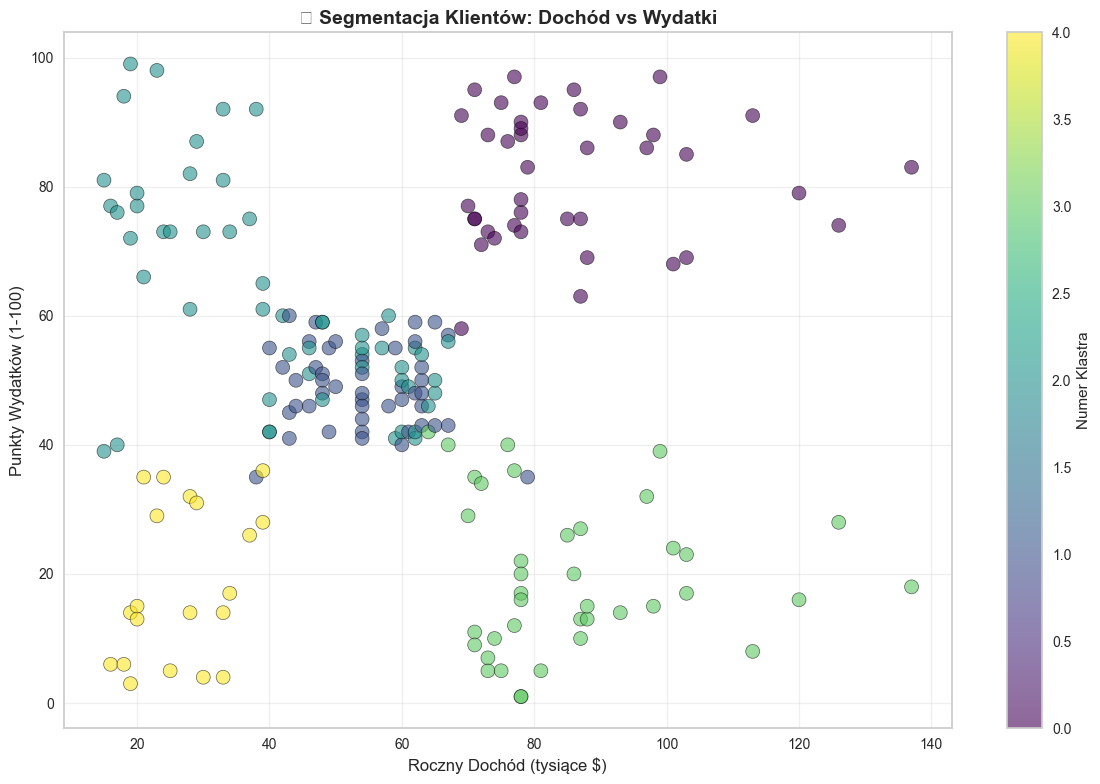


💡 Co widzimy na wykresie?
   Każdy kolor to inna grupa klientów.
   Klienci z podobnymi dochodami i wydatkami są zgrupowani razem.


In [14]:
# Wykres 1: Dochód vs Wydatki (najpopularniejszy)
# Konwertujemy klastry na liczby (PyCaret zwraca je jako 'Cluster 0', 'Cluster 1' etc.)
cluster_numeric = df['Cluster'].str.replace('Cluster ', '').astype(int)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df['Annual Income (k$)'],
    df['Spending Score (1-100)'],
    c=cluster_numeric,  # Używamy numerycznych wartości klastrów
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Numer Klastra')
plt.xlabel('Roczny Dochód (tysiące $)', fontsize=12)
plt.ylabel('Punkty Wydatków (1-100)', fontsize=12)
plt.title('💰 Segmentacja Klientów: Dochód vs Wydatki', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Co widzimy na wykresie?")
print("   Każdy kolor to inna grupa klientów.")
print("   Klienci z podobnymi dochodami i wydatkami są zgrupowani razem.")

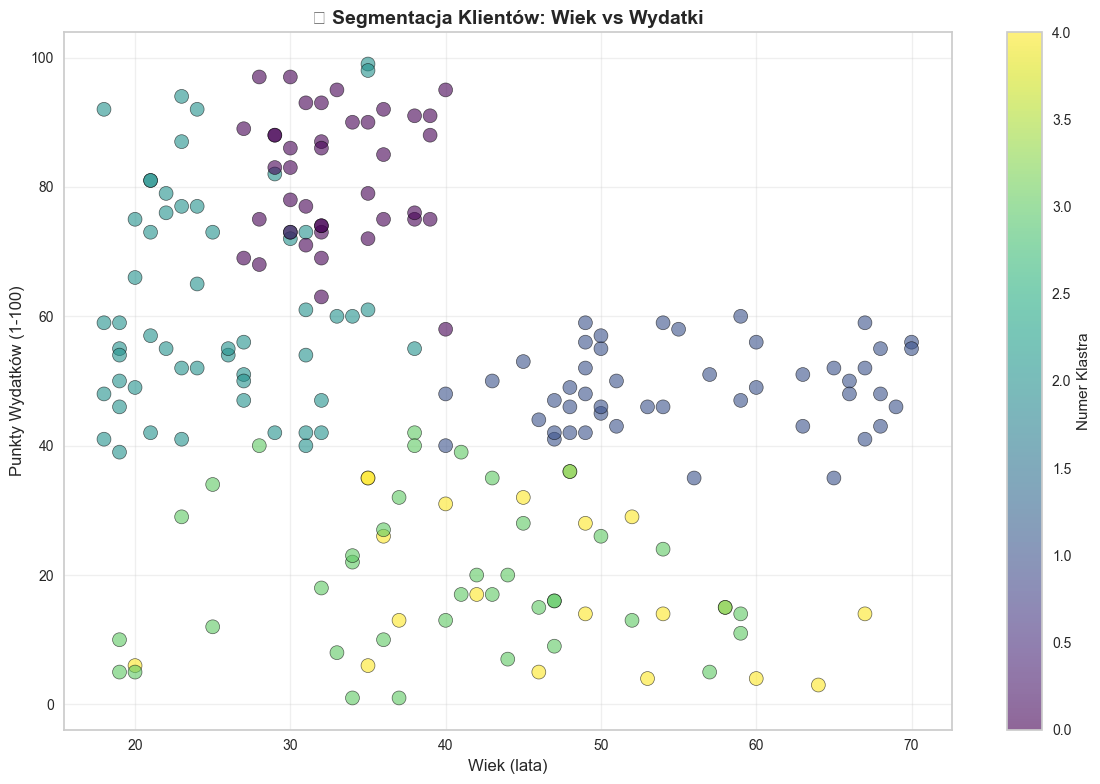

In [15]:
# Wykres 2: Wiek vs Wydatki
cluster_numeric = df['Cluster'].str.replace('Cluster ', '').astype(int)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df['Age'],
    df['Spending Score (1-100)'],
    c=cluster_numeric,
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Numer Klastra')
plt.xlabel('Wiek (lata)', fontsize=12)
plt.ylabel('Punkty Wydatków (1-100)', fontsize=12)
plt.title('👤 Segmentacja Klientów: Wiek vs Wydatki', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

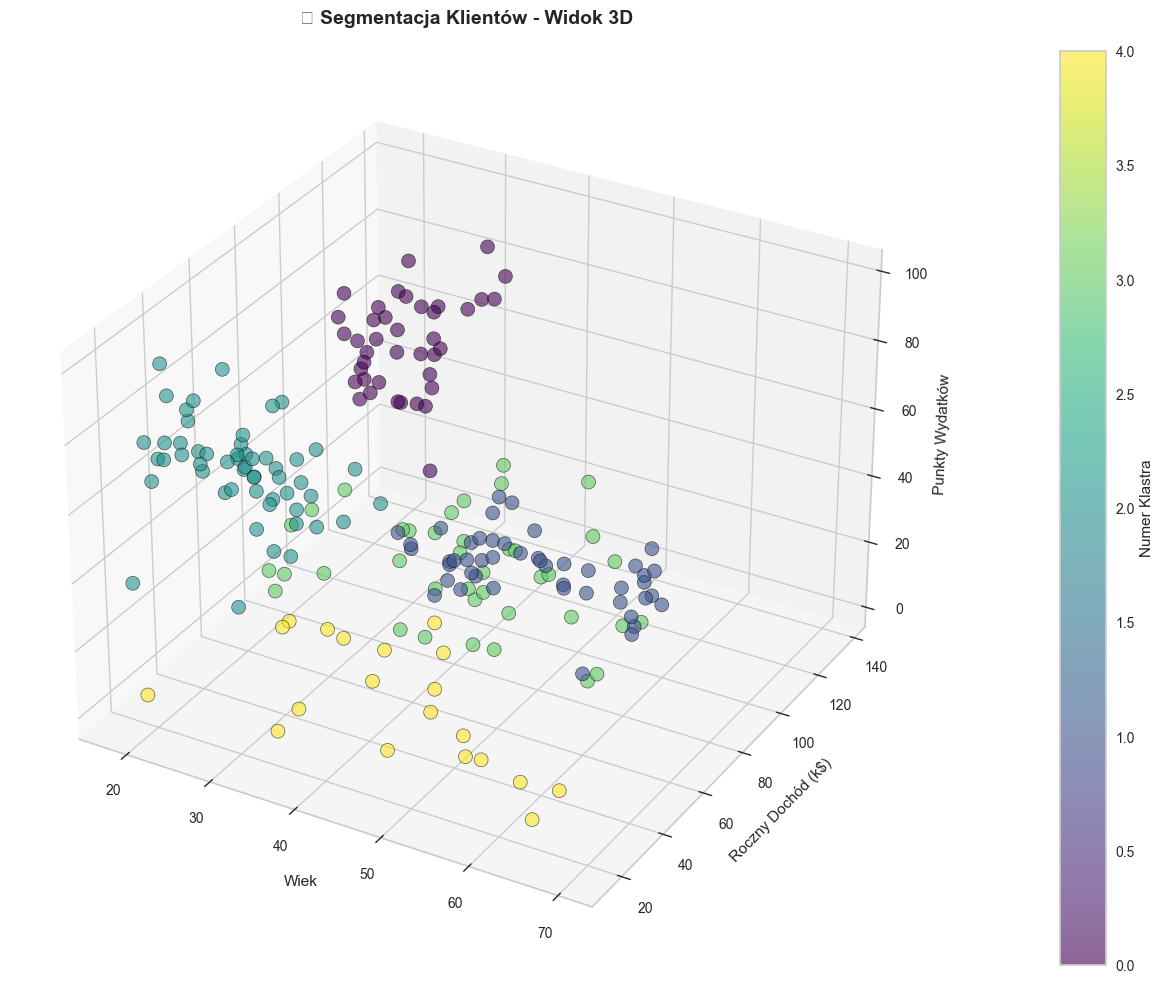


💡 Wykres 3D pokazuje wszystkie 3 cechy jednocześnie.
   Możesz obrócić wykres w VS Code, aby zobaczyć klastry z różnych perspektyw!


In [16]:
# Wykres 3: Wykres 3D - wszystkie 3 cechy naraz
from mpl_toolkits.mplot3d import Axes3D

cluster_numeric = df['Cluster'].str.replace('Cluster ', '').astype(int)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Age'],
    df['Annual Income (k$)'],
    df['Spending Score (1-100)'],
    c=cluster_numeric,
    cmap='viridis',
    s=100,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Wiek', fontsize=11, labelpad=10)
ax.set_ylabel('Roczny Dochód (k$)', fontsize=11, labelpad=10)
ax.set_zlabel('Punkty Wydatków', fontsize=11, labelpad=10)
ax.set_title('🎯 Segmentacja Klientów - Widok 3D', fontsize=14, fontweight='bold', pad=20)

plt.colorbar(scatter, label='Numer Klastra', pad=0.1)
plt.tight_layout()
plt.show()

print("\n💡 Wykres 3D pokazuje wszystkie 3 cechy jednocześnie.")
print("   Możesz obrócić wykres w VS Code, aby zobaczyć klastry z różnych perspektyw!")

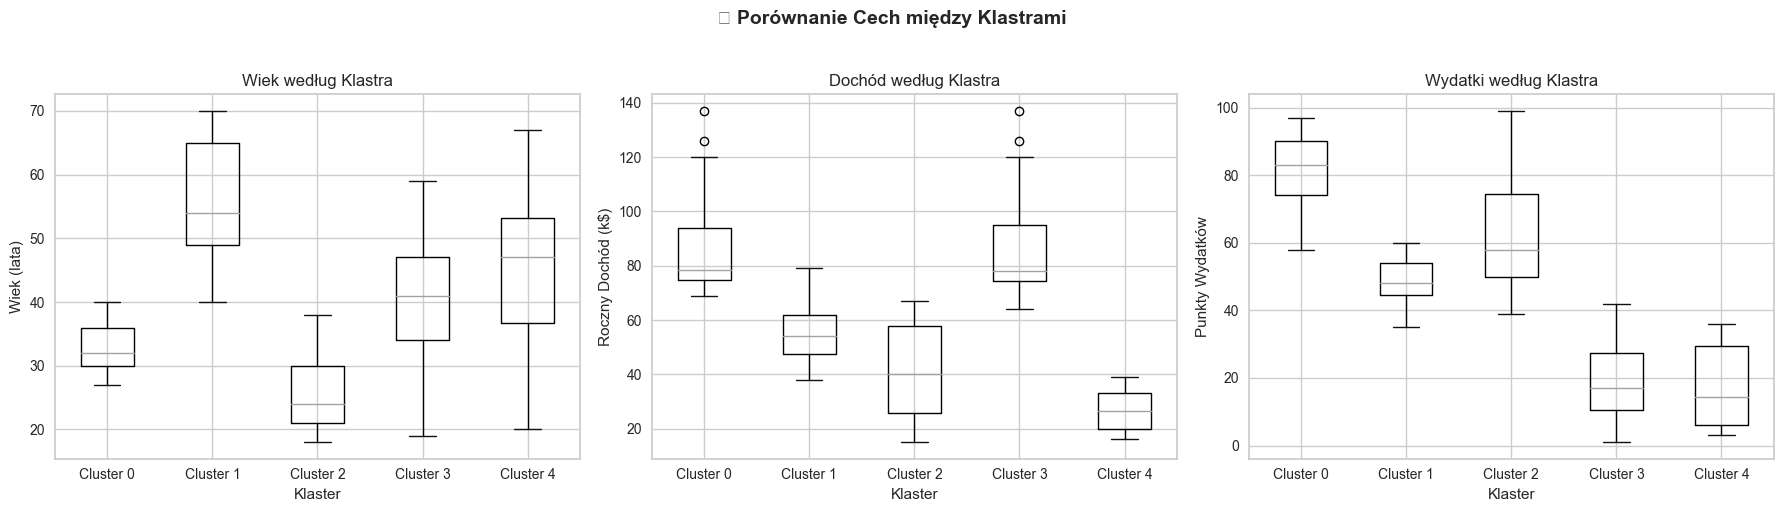


💡 Box ploty pokazują rozkład wartości w każdym klastrze.
   Prostokąt = 50% środkowych wartości, linia w środku = mediana.


In [17]:
# Wykres 4: Porównanie cech między klastrami (box plot)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Wiek
df.boxplot(column='Age', by='Cluster', ax=axes[0])
axes[0].set_title('Wiek według Klastra')
axes[0].set_xlabel('Klaster')
axes[0].set_ylabel('Wiek (lata)')

# Dochód
df.boxplot(column='Annual Income (k$)', by='Cluster', ax=axes[1])
axes[1].set_title('Dochód według Klastra')
axes[1].set_xlabel('Klaster')
axes[1].set_ylabel('Roczny Dochód (k$)')

# Wydatki
df.boxplot(column='Spending Score (1-100)', by='Cluster', ax=axes[2])
axes[2].set_title('Wydatki według Klastra')
axes[2].set_xlabel('Klaster')
axes[2].set_ylabel('Punkty Wydatków')

plt.suptitle('📊 Porównanie Cech między Klastrami', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Box ploty pokazują rozkład wartości w każdym klastrze.")
print("   Prostokąt = 50% środkowych wartości, linia w środku = mediana.")

## Krok 10: Wizualizacje z PyCaret

PyCaret ma wbudowane funkcje do wizualizacji klastrów!

**PCA (Principal Component Analysis)** to technika, która **upraszcza dane** z wielu wymiarów do 2D, żeby można było je narysować.

🎯 Co to jest PCA?

**Dla nietechnicznej osoby:**
Wyobraź sobie, że masz pudełko 3D (wiek, dochód, wydatki), a chcesz je sfotografować na płaskim papierze 2D. PCA znajduje **najlepszy kąt do zrobienia zdjęcia**, żeby zachować jak najwięcej informacji.

**Technicznie:**
PCA redukuje 3 cechy (Age, Income, Spending) do 2 nowych cech (PCA1 i PCA2), które wyjaśniają najwięcej zmienności w danych.

📊 Co to są osie na wykresie?

**PCA1 (oś X)**
- **Pierwszy Komponent Główny**
- Najważniejszy wymiar - wyjaśnia największą część różnic między klientami
- W Twoim przypadku prawdopodobnie reprezentuje głównie **dochód i wydatki** (najbardziej zmienne cechy)

**PCA2 (oś Y)**
- **Drugi Komponent Główny**  
- Drugi co do ważności wymiar - wyjaśnia drugą największą część różnic
- Prawdopodobnie reprezentuje **wiek** lub kombinację cech niezależną od PCA1

**Im dalej od siebie grupy kolorów, tym bardziej różni się profil klientów!**

💡 Dlaczego PCA jest przydatne?

✅ **3D → 2D** - możemy zobaczyć grupy na ekranie  
✅ **Łatwiej zrozumieć** - jeden prosty wykres zamiast 3 oddzielnych  
✅ **Szybka ocena** - od razu widać, czy klastry się oddzielają

**Pamiętaj:** To uproszczenie! Trochę informacji zostaje utraconych, ale wizualizacja jest czytelna.

In [18]:
# PyCaret - wykres klastrów
plot_model(kmeans_model, plot='cluster')
print("\n✅ Wykres PCA: Dane 3D zredukowane do 2D (łatwiej zobaczyć grupy)")


✅ Wykres PCA: Dane 3D zredukowane do 2D (łatwiej zobaczyć grupy)


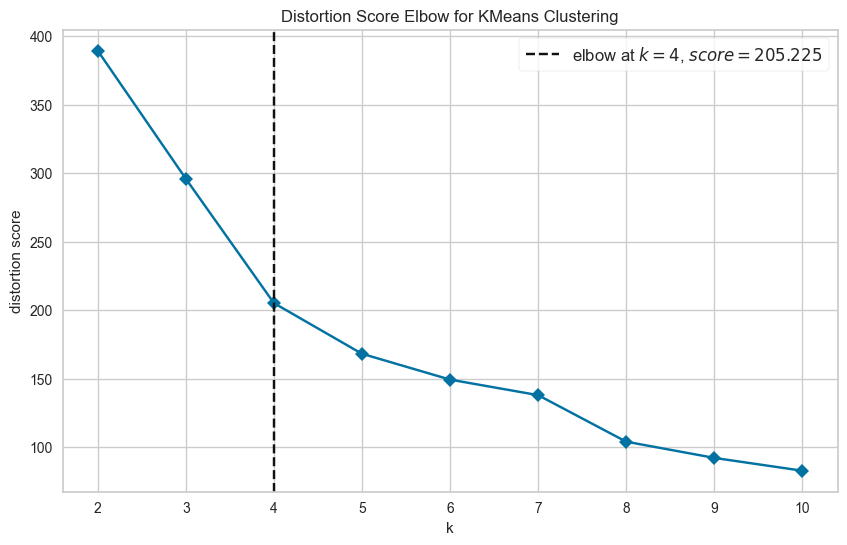


✅ Wykres Elbow od PyCaret


In [20]:
# PyCaret - wykres Elbow (alternatywna wersja)
plot_model(kmeans_model, plot='elbow')
print("\n✅ Wykres Elbow od PyCaret")

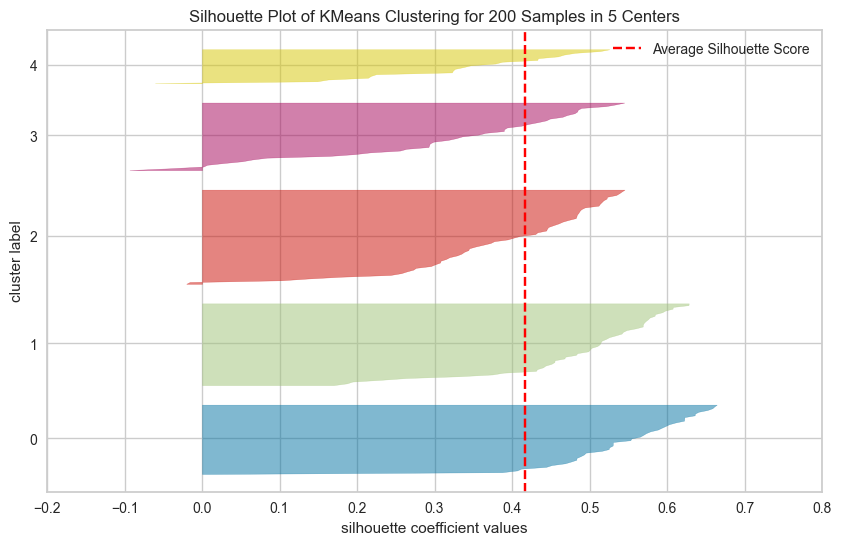


💡 Silhouette Score: Im wyższy (bliżej 1), tym lepiej oddzielone grupy.
   Wartość > 0.5 to dobry wynik!


In [21]:
# PyCaret - Silhouette Plot (jak dobrze oddzielone są klastry)
plot_model(kmeans_model, plot='silhouette')
print("\n💡 Silhouette Score: Im wyższy (bliżej 1), tym lepiej oddzielone grupy.")
print("   Wartość > 0.5 to dobry wynik!")

## Krok 11: Zapisanie wyników i modelu

Zapisujemy:
1. **Model** - żeby móc go później użyć bez ponownego trenowania
2. **Dane z klastrami** - do analizy w Excel lub innych narzędziach

In [22]:
# Zapisujemy wytrenowany model
save_model(kmeans_model, 'models/customer_segmentation_model')

print("✅ Model zapisany w folderze 'models/'")
print("   Możesz go później wczytać i użyć do nowych klientów!")

Transformation Pipeline and Model Successfully Saved
✅ Model zapisany w folderze 'models/'
   Możesz go później wczytać i użyć do nowych klientów!


In [23]:
# Zapisujemy dane z przypisanymi klastrami do CSV
df.to_csv('data/customers_with_clusters.csv', index=False)

print("✅ Dane z klastrami zapisane do 'data/customers_with_clusters.csv'")
print("   Możesz otworzyć ten plik w Excel i dalej analizować!")

✅ Dane z klastrami zapisane do 'data/customers_with_clusters.csv'
   Możesz otworzyć ten plik w Excel i dalej analizować!


## Krok 12: Jak użyć modelu dla nowych klientów?

Gdy przyjdzie nowy klient, możemy go przypisać do odpowiedniego klastra!

In [24]:
# Przykład: Nowy klient
new_customer = pd.DataFrame({
    'Age': [28],
    'Annual Income (k$)': [75],
    'Spending Score (1-100)': [80]
})

print("🆕 Nowy klient:")
print(f"   Wiek: {new_customer['Age'].values[0]} lat")
print(f"   Dochód roczny: ${new_customer['Annual Income (k$)'].values[0]}k")
print(f"   Punkty wydatków: {new_customer['Spending Score (1-100)'].values[0]}/100")

# Przypisujemy nowego klienta do klastra
prediction = predict_model(kmeans_model, data=new_customer)
assigned_cluster = prediction['Cluster'].values[0]

print(f"\n✅ Nowy klient został przypisany do KLASTRA {assigned_cluster}")
print(f"\n💡 Możesz teraz skierować do niego odpowiednią kampanię marketingową")
print(f"   na podstawie charakterystyki tego klastra (zobacz Krok 8 powyżej)!")

🆕 Nowy klient:
   Wiek: 28 lat
   Dochód roczny: $75k
   Punkty wydatków: 80/100

✅ Nowy klient został przypisany do KLASTRA Cluster 0

💡 Możesz teraz skierować do niego odpowiednią kampanię marketingową
   na podstawie charakterystyki tego klastra (zobacz Krok 8 powyżej)!


## 🎉 Podsumowanie

### Co zrobiliśmy?
1. ✅ Wczytaliśmy dane klientów centrum handlowego
2. ✅ Użyliśmy PyCaret do automatycznego przygotowania danych
3. ✅ Wybraliśmy optymalną liczbę klastrów (metodą Elbow)
4. ✅ Stworzyliśmy model K-Means do segmentacji
5. ✅ Przypisaliśmy każdego klienta do odpowiedniej grupy
6. ✅ Przeanalizowaliśmy charakterystykę każdej grupy
7. ✅ Stworzyliśmy wizualizacje klastrów
8. ✅ Zapisaliśmy model i wyniki

### Co dalej?
- **Marketing** może teraz stworzyć dedykowane kampanie dla każdej grupy
- **Sprzedaż** wie, jakie produkty oferować różnym klientom
- **Management** ma wgląd w strukturę bazy klientów

### Jak używać tego modelu?
1. Wczytaj zapisany model
2. Dla nowego klienta podaj: wiek, dochód, historię wydatków
3. Model automatycznie przypisze go do odpowiedniej grupy
4. Zastosuj strategię marketingową dla tej grupy!

---

**💡 Pamiętaj:** Machine Learning to narzędzie wspierające decyzje, nie zastępujące ludzi!
Zawsze łącz wyniki modelu z wiedzą biznesową i zdrowym rozsądkiem.